# Figure 1 Replication - Event-Time Leverage Paths (1965-2003)

This notebook replicates **Figure 1** from Lemmon, Roberts, and Zender (2008), showing event-time average leverage paths for portfolios formed by sorting on current leverage.

---


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
pd.set_option('display.width', 120)


Matplotlib is building the font cache; this may take a moment.


## STEP 1 — Load Cleaned Data from Q5

We'll use the cleaned and trimmed data from the Table 1 replication (Q5) that contains:
- `book_lev` = book leverage (total debt / total assets)
- `market_lev` = market leverage (total debt / (total debt + market equity))
- Both "All Firms" and "Survivors" datasets


In [3]:
# Load the trimmed data from Q5
df_full = pd.read_csv('../Q5/data/05_trimmed_data.csv')

print(f"Loaded {len(df_full):,} observations")
print(f"Unique firms: {df_full['gvkey'].nunique():,}")
print(f"Years: {df_full['fyear'].min()}-{df_full['fyear'].max()}")


Loaded 225,177 observations
Unique firms: 23,044
Years: 1965-2003


In [4]:
# Create the two datasets: All Firms and Survivors
# Survivors = firms with ≥20 years of book leverage data

lev_counts = df_full.groupby('gvkey')['book_lev'].count()
survivors = lev_counts[lev_counts >= 20].index

df_all = df_full.copy()
df_surv = df_full[df_full['gvkey'].isin(survivors)]

print(f"\nAll Firms: {len(df_all):,} observations, {df_all['gvkey'].nunique():,} unique firms")
print(f"Survivors: {len(df_surv):,} observations, {df_surv['gvkey'].nunique():,} unique firms")



All Firms: 225,177 observations, 23,044 unique firms
Survivors: 83,975 observations, 2,952 unique firms


## STEP 2 — Understanding Figure 1 Methodology

Figure 1 shows **event-time average leverage paths** using the following procedure:

1. **Formation Year (Event Year 0)**: Each year from 1965-2003, sort all firms into **4 leverage quartiles** (Low, Medium, High, Very High) based on their current leverage.

2. **Fixed Membership**: Keep portfolio membership **fixed** from the formation year. Track the same firms forward for up to 20 years.

3. **Track Forward**: For each event year (0, 1, 2, ..., 20), compute the **mean leverage** for firms still reporting in that year. Firms that exit (delist, go missing) simply drop out of the average.

4. **Average Across Formation Years**: Repeat steps 1-3 for all formation years. For each event year, **average the means across all formation-year cohorts** to get the final event-time path.

5. **Confidence Intervals**: Compute the **standard error** within each formation-year cohort, then take the **average SE across cohorts** for each event year. The 95% CI is approximately mean ± 2×avg_SE.

6. **Four Panels**:
   - Panel A: Book leverage, All firms
   - Panel B: Book leverage, Survivors
   - Panel C: Market leverage, All firms
   - Panel D: Market leverage, Survivors


## STEP 3 — Implement Event-Time Portfolio Analysis Function

This function encapsulates the entire Figure 1 methodology:


In [5]:
# Portfolio labels
PORT_LABELS = ["Low", "Medium", "High", "Very High"]

def build_event_time_paths(df, lev_col, start_year=1965, end_year=2003, horizon=19):
    """
    Replicates the Figure 1 procedure:
    - Each formation year t0: sort firms into leverage quartiles using lev_col in year t0
    - Hold membership fixed; compute mean leverage for event years 0..horizon
    - Repeat for all t0; then average across t0 within each event year
    
    CI matches the paper's conservative approach:
    - Compute SE within each formation-year set
    - For each event year, take average SE across sets
    - 95% CI approx = mean +/- 2 * avg_SE
    """
    df = df.copy()
    df = df[df["fyear"].between(start_year, end_year)]
    df = df[["gvkey", "fyear", lev_col]].dropna(subset=[lev_col])

    # Store per-formation-year results
    all_sets = []  # Each element: DataFrame indexed by event_year, columns=portfolios, values=means
    all_ses  = []  # Same, but standard errors

    years = range(start_year, end_year + 1)

    for t0 in years:
        base = df[df["fyear"] == t0][["gvkey", lev_col]].dropna()
        if base.empty or base["gvkey"].nunique() < 50:
            continue  # Skip tiny formation years

        # Assign quartiles in formation year
        base = base.drop_duplicates("gvkey")
        try:
            base["port"] = pd.qcut(base[lev_col], 4, labels=PORT_LABELS)
        except ValueError:
            continue  # Not enough unique leverage values to form quartiles

        port_map = base.set_index("gvkey")["port"]

        means_by_k = pd.DataFrame(index=range(0, horizon + 1), columns=PORT_LABELS, dtype=float)
        ses_by_k   = pd.DataFrame(index=range(0, horizon + 1), columns=PORT_LABELS, dtype=float)

        for k in range(0, horizon + 1):
            yr = t0 + k
            if yr > end_year:
                continue

            tmp = df[df["fyear"] == yr].copy()
            tmp["port"] = tmp["gvkey"].map(port_map)
            tmp = tmp.dropna(subset=["port", lev_col])

            # Mean + SE per portfolio (firms can exit; you just average whoever remains)
            g = tmp.groupby("port")[lev_col]
            means = g.mean()
            ses   = g.std(ddof=1) / np.sqrt(g.count())

            for p in PORT_LABELS:
                means_by_k.loc[k, p] = means.get(p, np.nan)
                ses_by_k.loc[k, p]   = ses.get(p, np.nan)

        all_sets.append(means_by_k)
        all_ses.append(ses_by_k)

    # Average across formation-year sets within each event year (ignore missing)
    mean_path = pd.concat(all_sets).groupby(level=0).mean()
    avg_se    = pd.concat(all_ses).groupby(level=0).mean()

    ci_low  = mean_path - 2 * avg_se
    ci_high = mean_path + 2 * avg_se

    return mean_path, ci_low, ci_high

print("Event-time analysis function defined successfully.")


Event-time analysis function defined successfully.


## STEP 4 — Generate All Four Panels

Now we'll run the analysis for:
- Panel A: Book leverage, All firms
- Panel B: Book leverage, Survivors
- Panel C: Market leverage, All firms
- Panel D: Market leverage, Survivors


In [6]:
print("Computing Panel A: Book leverage, All firms...")
A_mean, A_lo, A_hi = build_event_time_paths(df_all, "book_lev", horizon=19)
print("✓ Panel A complete")

print("\nComputing Panel B: Book leverage, Survivors...")
B_mean, B_lo, B_hi = build_event_time_paths(df_surv, "book_lev", horizon=19)
print("✓ Panel B complete")

print("\nComputing Panel C: Market leverage, All firms...")
C_mean, C_lo, C_hi = build_event_time_paths(df_all, "market_lev", horizon=19)
print("✓ Panel C complete")

print("\nComputing Panel D: Market leverage, Survivors...")
D_mean, D_lo, D_hi = build_event_time_paths(df_surv, "market_lev", horizon=19)
print("✓ Panel D complete")

print("\n" + "="*80)
print("All panels computed successfully!")
print("="*80)


Computing Panel A: Book leverage, All firms...


/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

✓ Panel A complete

Computing Panel B: Book leverage, Survivors...


/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

✓ Panel B complete

Computing Panel C: Market leverage, All firms...


/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

✓ Panel C complete

Computing Panel D: Market leverage, Survivors...


/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

✓ Panel D complete

All panels computed successfully!


/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby("port")[lev_col]
/var/folders/76/ft9x21154txd7ypyb05jb7xc0000gn/T/ipykernel_16112/2424788498.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

## STEP 5 — Plot the Four-Panel Figure

Create a 2×2 figure showing all four panels with solid lines for means and dashed lines for 95% confidence intervals.


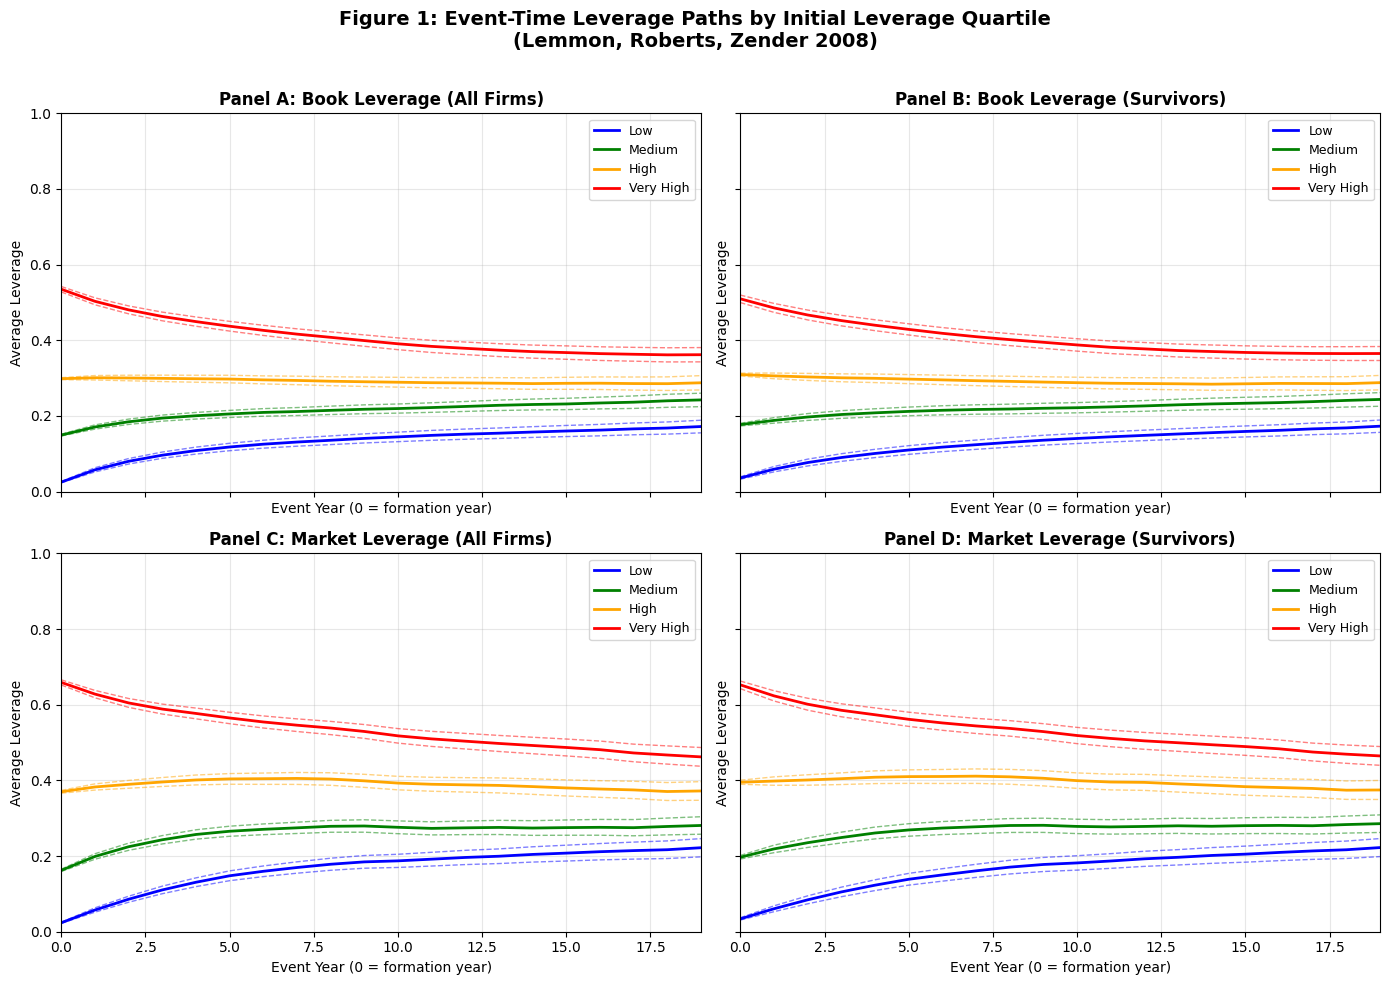


Figure saved as 'figure1_replication.png'


In [7]:
def plot_panel(ax, mean_df, lo_df, hi_df, title):
    """
    Plot a single panel with mean lines (solid) and 95% CI (dashed).
    """
    x = mean_df.index.values
    colors = ['blue', 'green', 'orange', 'red']  # One color per quartile
    
    for i, p in enumerate(PORT_LABELS):
        # Plot mean line
        ax.plot(x, mean_df[p].values, label=p, color=colors[i], linewidth=2)
        
        # Plot confidence interval bounds (dashed)
        ax.plot(x, lo_df[p].values, linestyle="--", color=colors[i], alpha=0.5, linewidth=1)
        ax.plot(x, hi_df[p].values, linestyle="--", color=colors[i], alpha=0.5, linewidth=1)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("Event Year (0 = formation year)", fontsize=10)
    ax.set_ylabel("Average Leverage", fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 19)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", frameon=True, fontsize=9)

# Create the 2×2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Figure 1: Event-Time Leverage Paths by Initial Leverage Quartile\n(Lemmon, Roberts, Zender 2008)', 
             fontsize=14, fontweight='bold')

plot_panel(axes[0,0], A_mean, A_lo, A_hi, "Panel A: Book Leverage (All Firms)")
plot_panel(axes[0,1], B_mean, B_lo, B_hi, "Panel B: Book Leverage (Survivors)")
plot_panel(axes[1,0], C_mean, C_lo, C_hi, "Panel C: Market Leverage (All Firms)")
plot_panel(axes[1,1], D_mean, D_lo, D_hi, "Panel D: Market Leverage (Survivors)")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('figure1_replication.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'figure1_replication.png'")


## STEP 6 — Examine Specific Quartile Paths

Let's print some actual numbers to quantify the persistence:


In [8]:
print("="*80)
print("PANEL A: BOOK LEVERAGE (ALL FIRMS)")
print("="*80)
print("\nEvent Year 0 (Formation):")
print(A_mean.loc[0])
print("\nEvent Year 10 (10 years later):")
print(A_mean.loc[10])
print("\nEvent Year 19 (19 years later):")
print(A_mean.loc[19])

# Calculate convergence
spread_t0 = A_mean.loc[0, "Very High"] - A_mean.loc[0, "Low"]
spread_t19 = A_mean.loc[19, "Very High"] - A_mean.loc[19, "Low"]
convergence_pct = (1 - spread_t19 / spread_t0) * 100

print(f"\nSpread between Very High and Low leverage:")
print(f"  Year 0:  {spread_t0:.3f}")
print(f"  Year 19: {spread_t19:.3f}")
print(f"  Convergence: {convergence_pct:.1f}% (only {convergence_pct:.1f}% of the initial spread has closed)")


PANEL A: BOOK LEVERAGE (ALL FIRMS)

Event Year 0 (Formation):
Low          0.025
Medium       0.149
High         0.299
Very High    0.535
Name: 0, dtype: float64

Event Year 10 (10 years later):
Low          0.145
Medium       0.220
High         0.289
Very High    0.391
Name: 10, dtype: float64

Event Year 19 (19 years later):
Low          0.172
Medium       0.242
High         0.288
Very High    0.362
Name: 19, dtype: float64

Spread between Very High and Low leverage:
  Year 0:  0.510
  Year 19: 0.190
  Convergence: 62.8% (only 62.8% of the initial spread has closed)


In [9]:
print("\n" + "="*80)
print("PANEL B: BOOK LEVERAGE (SURVIVORS)")
print("="*80)
print("\nEvent Year 0 (Formation):")
print(B_mean.loc[0])
print("\nEvent Year 19 (19 years later):")
print(B_mean.loc[19])

spread_t0_surv = B_mean.loc[0, "Very High"] - B_mean.loc[0, "Low"]
spread_t19_surv = B_mean.loc[19, "Very High"] - B_mean.loc[19, "Low"]
convergence_pct_surv = (1 - spread_t19_surv / spread_t0_surv) * 100

print(f"\nSpread between Very High and Low leverage:")
print(f"  Year 0:  {spread_t0_surv:.3f}")
print(f"  Year 19: {spread_t19_surv:.3f}")
print(f"  Convergence: {convergence_pct_surv:.1f}% (Survivors show EVEN LESS convergence)")



PANEL B: BOOK LEVERAGE (SURVIVORS)

Event Year 0 (Formation):
Low          0.036
Medium       0.177
High         0.310
Very High    0.510
Name: 0, dtype: float64

Event Year 19 (19 years later):
Low          0.173
Medium       0.244
High         0.288
Very High    0.365
Name: 19, dtype: float64

Spread between Very High and Low leverage:
  Year 0:  0.474
  Year 19: 0.192
  Convergence: 59.4% (Survivors show EVEN LESS convergence)


## STEP 7 — Save Results

Export the event-time paths to CSV for further analysis:


In [10]:
# Save all panel results
A_mean.to_csv('panel_A_book_all_mean.csv')
A_lo.to_csv('panel_A_book_all_ci_low.csv')
A_hi.to_csv('panel_A_book_all_ci_high.csv')

B_mean.to_csv('panel_B_book_surv_mean.csv')
B_lo.to_csv('panel_B_book_surv_ci_low.csv')
B_hi.to_csv('panel_B_book_surv_ci_high.csv')

C_mean.to_csv('panel_C_market_all_mean.csv')
C_lo.to_csv('panel_C_market_all_ci_low.csv')
C_hi.to_csv('panel_C_market_all_ci_high.csv')

D_mean.to_csv('panel_D_market_surv_mean.csv')
D_lo.to_csv('panel_D_market_surv_ci_low.csv')
D_hi.to_csv('panel_D_market_surv_ci_high.csv')

print("All results exported to CSV files!")


All results exported to CSV files!
